# Scaling

In this notebook, we train a ResNet model with stretched images to correctly classify with high accuracy whether an image contains an invasive species of hydrangea.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Load Datasets

We load the Invasive Species Dataset. It assumes the dataset is stored according to format of an ImageFolder dataset.

In [2]:
from torchvision import datasets, models, transforms
import os
from ScaleSquareTransform import ScaleSquare
cwd = os.getcwd()

data_transforms = {
    'train': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
}

data_dir = os.path.join(cwd,"dataset")
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print_every = 100
model_save_dir = os.path.join(cwd,"model_params_scaling.pth")


In [3]:
print(dset_classes)

['0', '1']


In [4]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

## Image sample
Plot an image just to make sure we have something that makes sense.

In [49]:
import torchvision.utils
import matplotlib.pyplot as plt

to_pil = torchvision.transforms.ToPILImage()

def show_img(inp):
    img = to_pil(inp)
    plt.imshow(img)

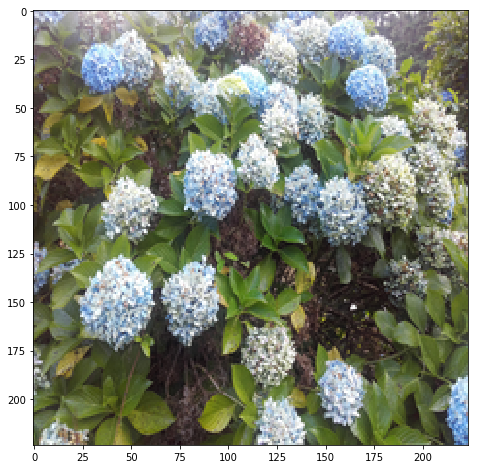

In [50]:
inputs, classes = next(iter(dset_loaders['train']))
show_img(inputs[0])

## Training
We use the following helper function to help us train a model.

In [5]:
def train(model, loss_fn, loader, optimizer, num_epochs = 1, print_every=100):
    loss_history = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            loss_data = loss.data[0]
            loss_history.append(loss_data)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss_data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_history

def check_accuracy(model, loader, return_errors=False, is_testing=False):
    if not is_testing:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        if return_errors:
            for i,x_i in enumerate(x):
                if (preds[i]!=y[i])[0] == 1:
                    incorrect_x[preds[i][0]].append(x_i)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x

In [6]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

Given the results from the training, we train one model 5 times on the best hyperparameters for 2 epochs and save the results.

In [7]:
# Here we use transfer learning to create a good model based on resnet.
# best acc 0.9703872437357631, beta0 0.95, beta1 0.995, reg 0.0018627520611745705, lr -4.05194392122697
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.cuda()
model.load_state_dict(torch.load(model_save_dir))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=10**-4.05194, betas=(0.95, 0.995), weight_decay=0.00186)

In [8]:
acc, incorrects = check_accuracy(model, dset_loaders["val"], True)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Checking accuracy on validation set
Got 431 / 439 correct (98.18)
False negatives: 5
False positives: 3


## False Positives and False Negatives
Here we plot all of the false positives and false negatives.

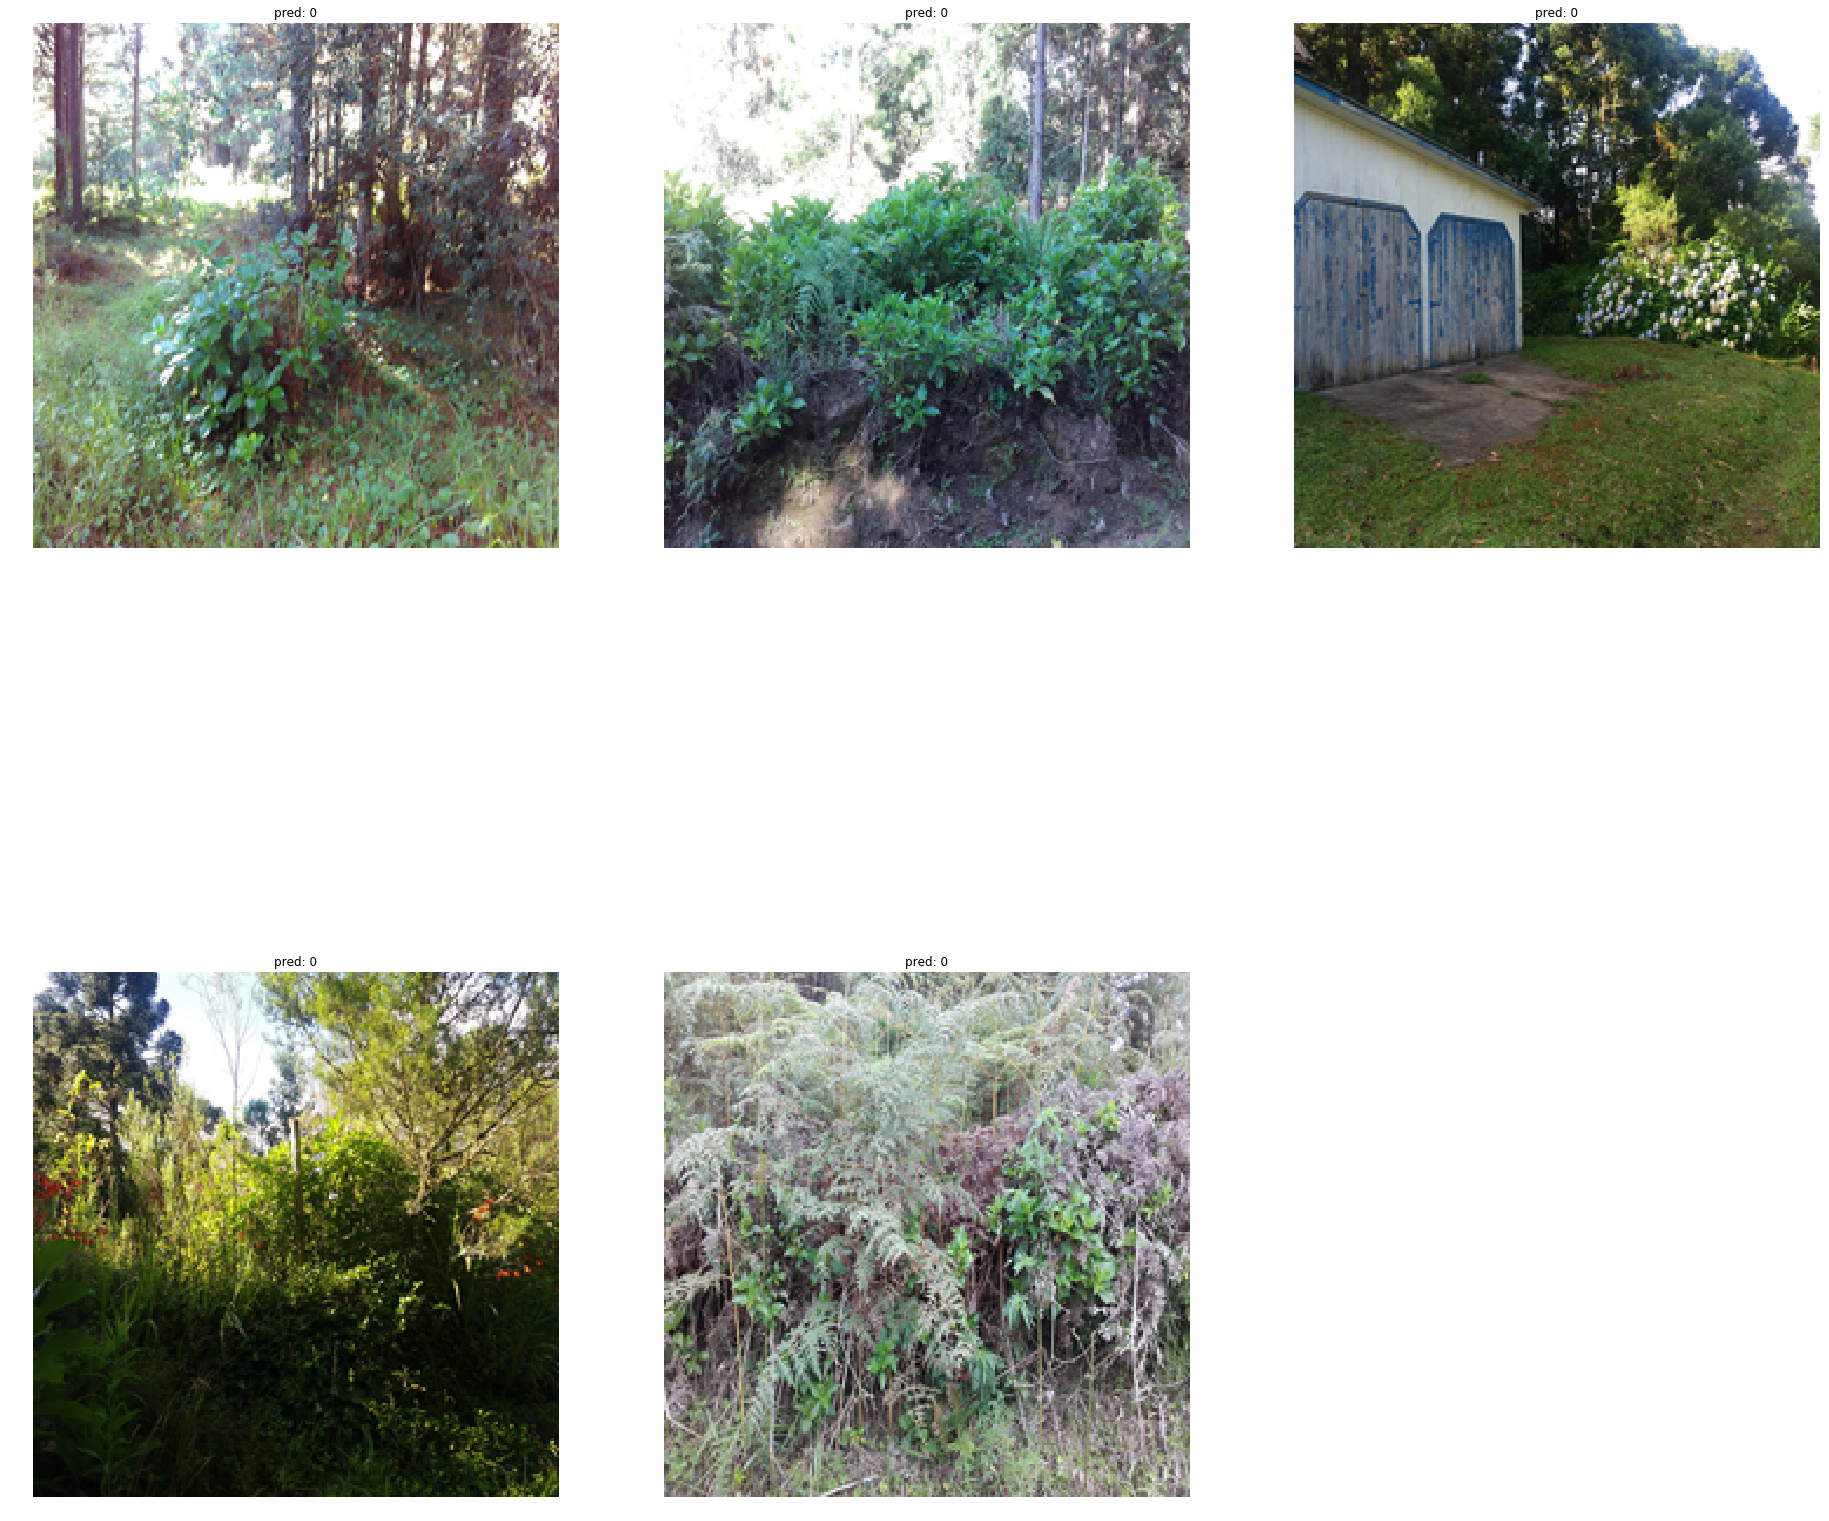

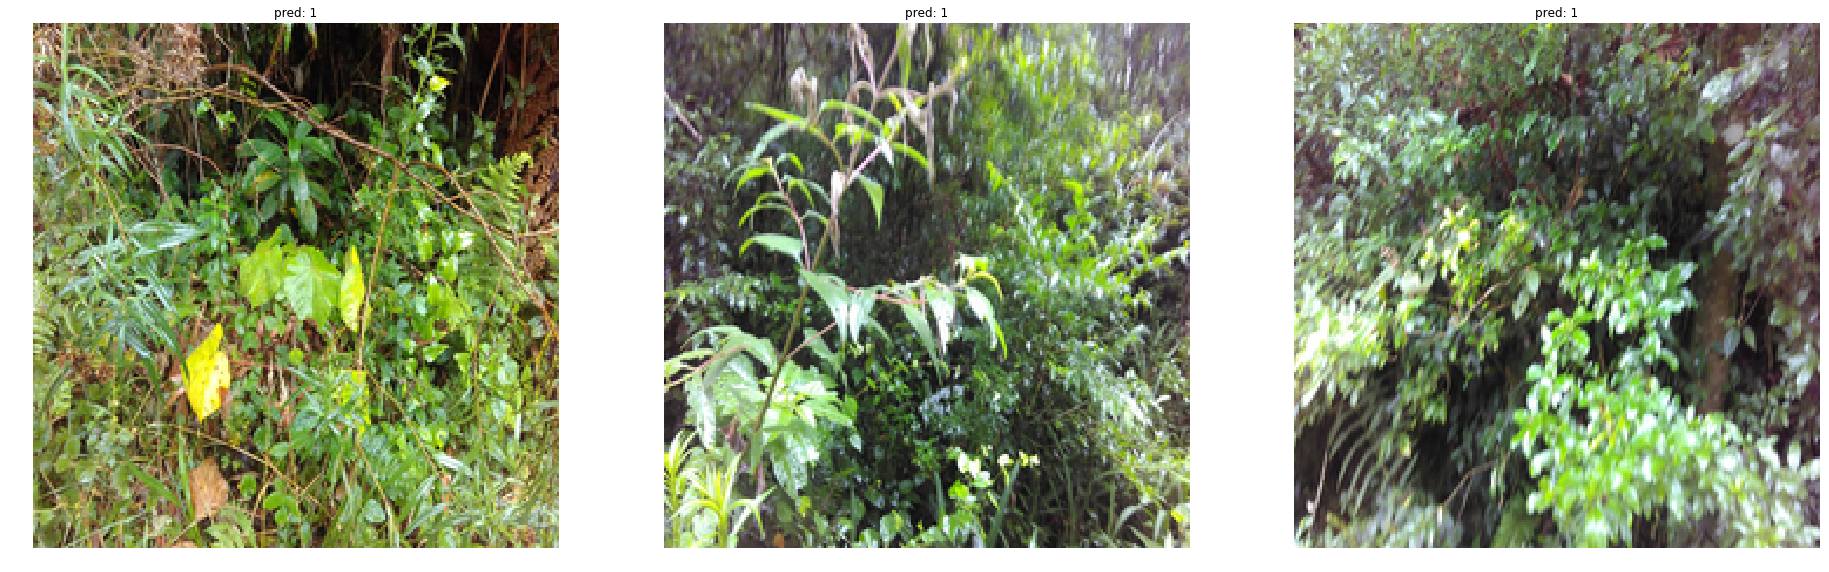

In [16]:
def plot_images(imgs, label):
    num_images = len(imgs)
    fig = plt.figure(figsize=(32, 32)) 
    for j in range(num_images):
        ax = plt.subplot(num_images//3+1, 3, j+1)
        ax.axis('off')
        ax.set_title('pred: {}'.format(label))
        show_img(imgs[j])

plot_images(incorrects[0], "0")
plot_images(incorrects[1], "1")

## Fooling Images
Let's now take a look at the fooling images for the false positives and false negatives and see if we can train them to be correctly classified. (Thank you assignment 3!)

In [79]:
gpu_dtype = torch.cuda.FloatTensor

def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and wrap it in a Variable.
    X_fooling = X.clone().type(gpu_dtype)
    X_fooling_var = Variable(X_fooling, requires_grad=True)
    
    learning_rate = 1
    N, D, H, W = X_fooling.size()
    y_var = Variable(torch.cuda.LongTensor(N).fill_(target_y))
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    print(y_var.data[0])
    for t in range(5):
        X_fooling_var = Variable(X_fooling, requires_grad=True)
        scores = model(X_fooling_var)
        y_pred_score, y_pred = scores.max(1)
        print("pred score, index",y_pred_score.data[0,0], y_pred.data[0,0])
        print("target score",scores.data[0,target_y])
        loss = loss_fn(scores, y_var)
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
        loss.backward()
        dX = X_fooling_var.grad.data/X_fooling_var.grad.data.norm()
        X_fooling -= learning_rate*dX
    return X_fooling

In [80]:
#X_fooling_np = X_fooling.cpu().clone()#deprocess(X_fooling.cpu().clone())
#X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

def show_fooling(X_tensor, X_fooling, idx, target_label, pred_label):
    x_fooling_cpu = X_fooling.cpu().clone().squeeze(0)
    x_cpu = X_tensor[idx].cpu()
    x_orig_img = to_pil(x_cpu)
    x_fooling = to_pil(x_fooling_cpu)

    plt.subplot(1, 4, 1)
    plt.imshow(x_orig_img)
    plt.title(pred_label)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(x_fooling)
    plt.title(target_label)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    #X_pre = preprocess(Image.fromarray(X[idx]))
    #diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
    diff = x_fooling_cpu-x_cpu
    plt.imshow(to_pil(diff))
    plt.title('Difference')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    #diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
    plt.imshow(to_pil(diff*10))
    plt.title('Magnified difference (10x)')
    plt.axis('off')

    plt.gcf().set_size_inches(12, 5)
    plt.show()

In [84]:
def run_fooling(errors, target_y):
    X = errors
    for idx, error in enumerate(errors):
        X_tensor_idx = torch.cat([x.cpu().unsqueeze(0) for x in X], 0)#torch.cat([preprocess(Image.fromarray(x)) for x in X], 0)
        X_fooling_idx = make_fooling_image(X_tensor_idx[idx:idx+1], target_y, model)

        scores = model(Variable(X_fooling_idx))
        assert target_y == scores.data.max(1)[1][0, 0], 'The model is not fooled!'

        show_fooling(X_tensor_idx, X_fooling_idx, idx, str(target_y), str((target_y-1)**2))

1
pred score, index 1.8530906438827515 0
target score -1.4501556158065796
t = 1, loss = 3.3394
pred score, index 2.6705174446105957 1
target score 2.6705174446105957
t = 2, loss = 0.0026
pred score, index 6.585834980010986 1
target score 6.585834980010986
t = 3, loss = 0.0000
pred score, index 10.081747055053711 1
target score 10.081747055053711
t = 4, loss = 0.0000
pred score, index 12.592447280883789 1
target score 12.592447280883789
t = 5, loss = 0.0000


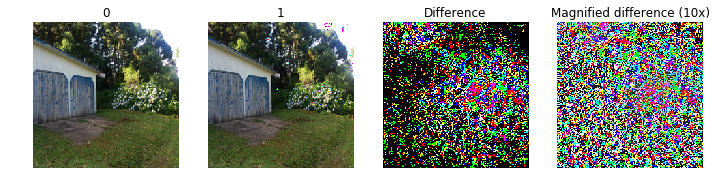

1
pred score, index 1.6653814315795898 0
target score -1.5841618776321411
t = 1, loss = 3.2876
pred score, index 1.6260732412338257 1
target score 1.6260732412338257
t = 2, loss = 0.0147
pred score, index 6.364718437194824 1
target score 6.364718437194824
t = 3, loss = 0.0000
pred score, index 10.392545700073242 1
target score 10.392545700073242
t = 4, loss = 0.0000
pred score, index 12.941654205322266 1
target score 12.941654205322266
t = 5, loss = 0.0000


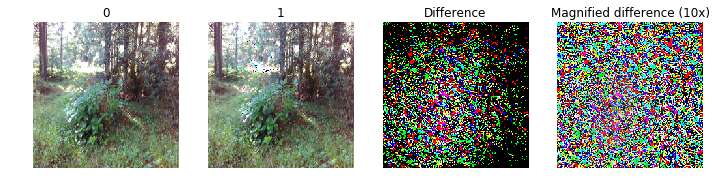

1
pred score, index 2.4959795475006104 0
target score -1.3243727684020996
t = 1, loss = 3.8420
pred score, index 0.6295164227485657 0
target score -0.026658279821276665
t = 2, loss = 1.0741
pred score, index 1.990356683731079 1
target score 1.990356683731079
t = 3, loss = 0.0190
pred score, index 4.6928324699401855 1
target score 4.6928324699401855
t = 4, loss = 0.0000
pred score, index 7.909659385681152 1
target score 7.909659385681152
t = 5, loss = 0.0000


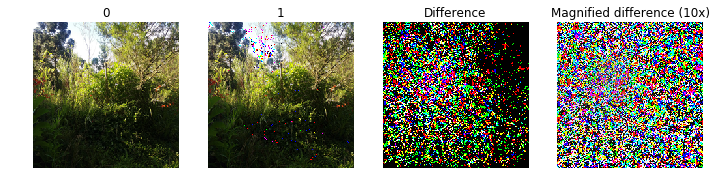

1
pred score, index 0.28768450021743774 0
target score 0.2229689508676529
t = 1, loss = 0.7260
pred score, index 4.350451469421387 1
target score 4.350451469421387
t = 2, loss = 0.0001
pred score, index 7.905521869659424 1
target score 7.905521869659424
t = 3, loss = 0.0000
pred score, index 11.009807586669922 1
target score 11.009807586669922
t = 4, loss = 0.0000
pred score, index 13.174776077270508 1
target score 13.174776077270508
t = 5, loss = 0.0000


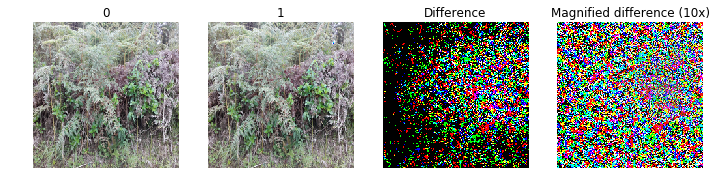

1
pred score, index 0.3710575997829437 0
target score -0.4645822048187256
t = 1, loss = 1.1958
pred score, index 3.4431333541870117 1
target score 3.4431333541870117
t = 2, loss = 0.0003
pred score, index 7.650413513183594 1
target score 7.650413513183594
t = 3, loss = 0.0000
pred score, index 11.715339660644531 1
target score 11.715339660644531
t = 4, loss = 0.0000
pred score, index 15.439393997192383 1
target score 15.439393997192383
t = 5, loss = 0.0000


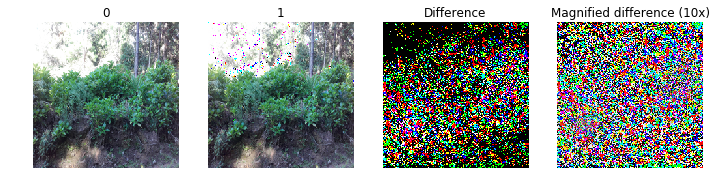

In [85]:
run_fooling(incorrects[0], 1)

0
pred score, index 0.11514569073915482 1
target score 0.009313888847827911
t = 1, loss = 0.7475
pred score, index 1.2905850410461426 0
target score 1.2905850410461426
t = 2, loss = 0.1060
pred score, index 2.348268747329712 0
target score 2.348268747329712
t = 3, loss = 0.0136
pred score, index 4.1764116287231445 0
target score 4.1764116287231445
t = 4, loss = 0.0007
pred score, index 5.840754985809326 0
target score 5.840754985809326
t = 5, loss = 0.0000


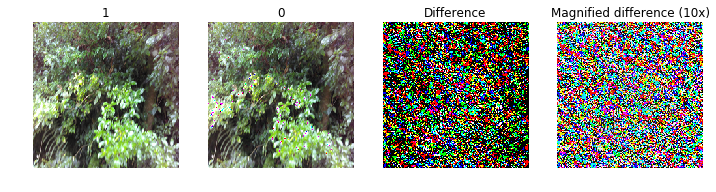

0
pred score, index 1.0856455564498901 1
target score -1.0763561725616455
t = 1, loss = 2.2709
pred score, index 1.0495494604110718 0
target score 1.0495494604110718
t = 2, loss = 0.2033
pred score, index 2.4257285594940186 0
target score 2.4257285594940186
t = 3, loss = 0.0200
pred score, index 3.9035861492156982 0
target score 3.9035861492156982
t = 4, loss = 0.0017
pred score, index 5.152259349822998 0
target score 5.152259349822998
t = 5, loss = 0.0002


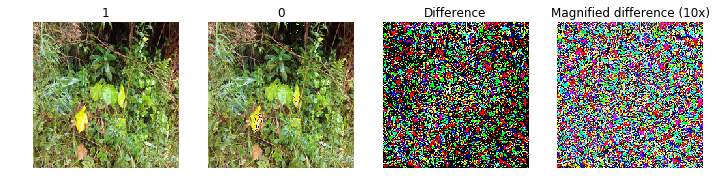

0
pred score, index -0.08445564657449722 1
target score -0.35889166593551636
t = 1, loss = 0.8398
pred score, index 1.4613769054412842 0
target score 1.4613769054412842
t = 2, loss = 0.0741
pred score, index 3.0210657119750977 0
target score 3.0210657119750977
t = 3, loss = 0.0060
pred score, index 4.198292255401611 0
target score 4.198292255401611
t = 4, loss = 0.0007
pred score, index 5.345434188842773 0
target score 5.345434188842773
t = 5, loss = 0.0001


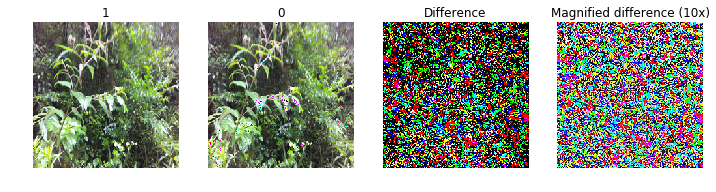

In [86]:
run_fooling(incorrects[1], 0)